# PREDICTING SUCCESS OF NEWLY OPENED RESTAURANTS

In this notebook, we will analyze the Zomato Bengalore Restaurants dataset. The goal of this project is to provide decision power for decision makers when looking at informations about Bengalore restaurants. For this we can:

- Get intuition about the data
- Do an exploratory data analysis
- Use graphical modules to visualize the data
- Apply a predictive point of view for helping people to choose the best restaurant.
- Using this predictive approach for predicting the success of a new restaurant in Bengaluru.

## 1. Libraries

In [14]:
# Standard libraries
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
from collections import Counter
from PIL import Image

# Viz libs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid.inset_locator import InsetPosition
import folium
from folium.plugins import HeatMap, FastMarkerCluster
from wordcloud import WordCloud

# Geolocation libs
from geopy.geocoders import Nominatim

# Utils modules
from custom_transformers import *
from viz_utils import *
from ml_utils import *

# ML libs
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import shap

## 2. Reading and Exploratory Data Analysis

In [25]:
# Reading restaurants data
data_path = 'zomato.csv'
df_restaurants = import_data(path=data_path, n_lines=5000)

# Results
print(f'Dataset shape: {df_restaurants.shape}')
df_restaurants.head()

This dataset has 17 columns, which 1 is/are applicable to optimization.

----------------------------------------------------
Memory usage (5000 lines): 0.6486 MB
Memory usage after optimization (5000 lines): 0.6295 MB
----------------------------------------------------

Reduction of 2.94% on memory usage

Dataset shape: (51717, 17)


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


We have the following columns

* **_url:_** contains the url of the restaurant in the zomato website;
* **_address:_** contains the address of the restaurant in Bengaluru;
* **_name:_** contains the name of the restaurant;
* **_online-order:_** whether online ordering is available in the restaurant or not;
* **_book-table:_** table book option available or not;
* **_rate:_** contains the overall rating of the restaurant out of 5;
* **_votes:_** contains total number of rating for the restaurant as of the above mentioned date;
* **_phone:_** contains the phone number of the restaurant;
* **_location:_** contains the neighborhood in which the restaurant is located;
* **_rest-type:_** restaurant type.

In [26]:
# Changing the data type from approx_cost columns
df_restaurants['approx_cost'] = df_restaurants['approx_cost(for two people)'].astype(str).apply(lambda x: x.replace(',', ''))
df_restaurants['approx_cost'] = df_restaurants['approx_cost'].astype(float)

# Extracting the rate in a float column
df_restaurants['rate_num'] = df_restaurants['rate'].astype(str).apply(lambda x: x.split('/')[0])
while True:
    try:
        df_restaurants['rate_num'] = df_restaurants['rate_num'].astype(float)
        break
    except ValueError as e1:
        noise_entry = str(e1).split(":")[-1].strip().replace("'", "")
        print(f'Threating noisy entrance on rate: {noise_entry}')
        df_restaurants['rate_num'] = df_restaurants['rate_num'].apply(lambda x: x.replace(noise_entry, str(np.nan)))

# Dropping old columns
df_restaurants.drop(['approx_cost(for two people)', 'rate'], axis=1, inplace=True)

Threating noisy entrance on rate: NEW
Threating noisy entrance on rate: -


### 2.1 Graphical Exploration

#### _(a) How many types of restaurants we have?_

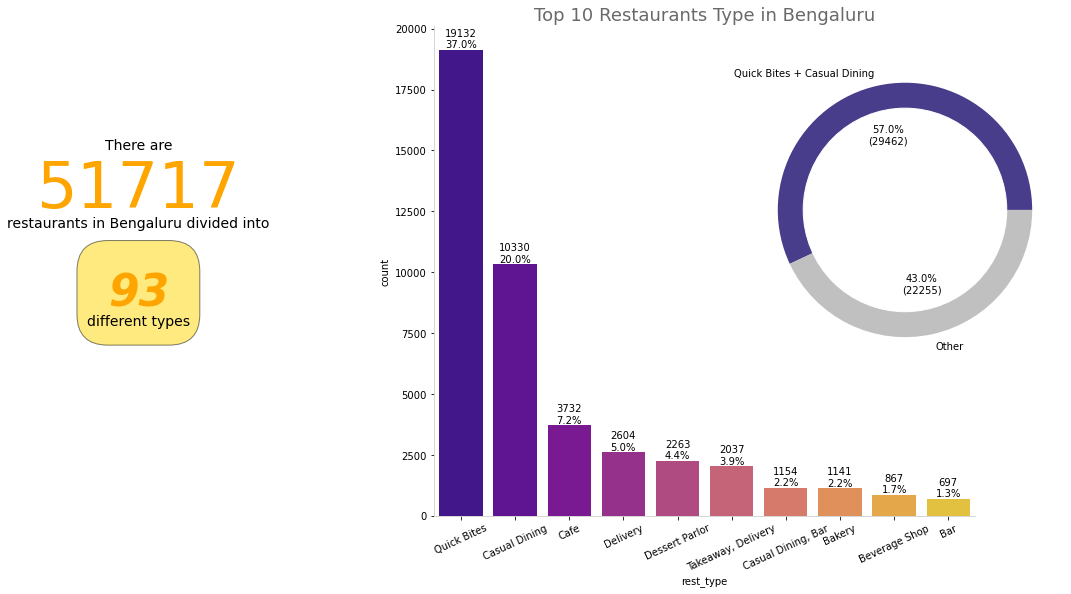

In [28]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(15, 9))

# Axis definition with GridSpec
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])

# Axis 1 - Big Number for total restaurants and total types in the data
total_restaurants = len(df_restaurants)
total_types = len(df_restaurants['rest_type'].value_counts())
ax1.text(0.00, 0.75, 'There are', fontsize=14, ha='center')
ax1.text(0.00, 0.63, f'{total_restaurants}', fontsize=64, color='orange', ha='center')
ax1.text(0, 0.59, 'restaurants in Bengaluru divided into', fontsize=14, ha='center')
ax1.text(0.00, 0.43, total_types, fontsize=44, ha='center', color='orange', style='italic', weight='bold',
         bbox=dict(facecolor='gold', alpha=0.5, pad=14, boxstyle='round, pad=.7'))
ax1.text(0, 0.39, 'different types', fontsize=14, ha='center')
ax1.axis('off')

# Axis 2 - Total number of restaurants per type (Top N)
top = 10
single_countplot(df_restaurants, ax2, x='rest_type', top=top)
ax2.set_title(f'Top {top} Restaurants Type in Bengaluru', color='dimgrey', size=18)
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)
    
# Axis 3 - Representative of the top two restaurant type
df_restaurants['top_types'] = df_restaurants['rest_type'].apply(lambda x: 'Quick Bites + Casual Dining' if x in ('Quick Bites', 'Casual Dining') else 'Other')
ax3 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax2, [0.57, 0.3, 0.6, 0.65])
ax3.set_axes_locator(ip)
donut_plot(df_restaurants, col='top_types', ax=ax3, colors=['darkslateblue', 'silver'], title='')

#### _(b) Top 10 cuisines available across the city_

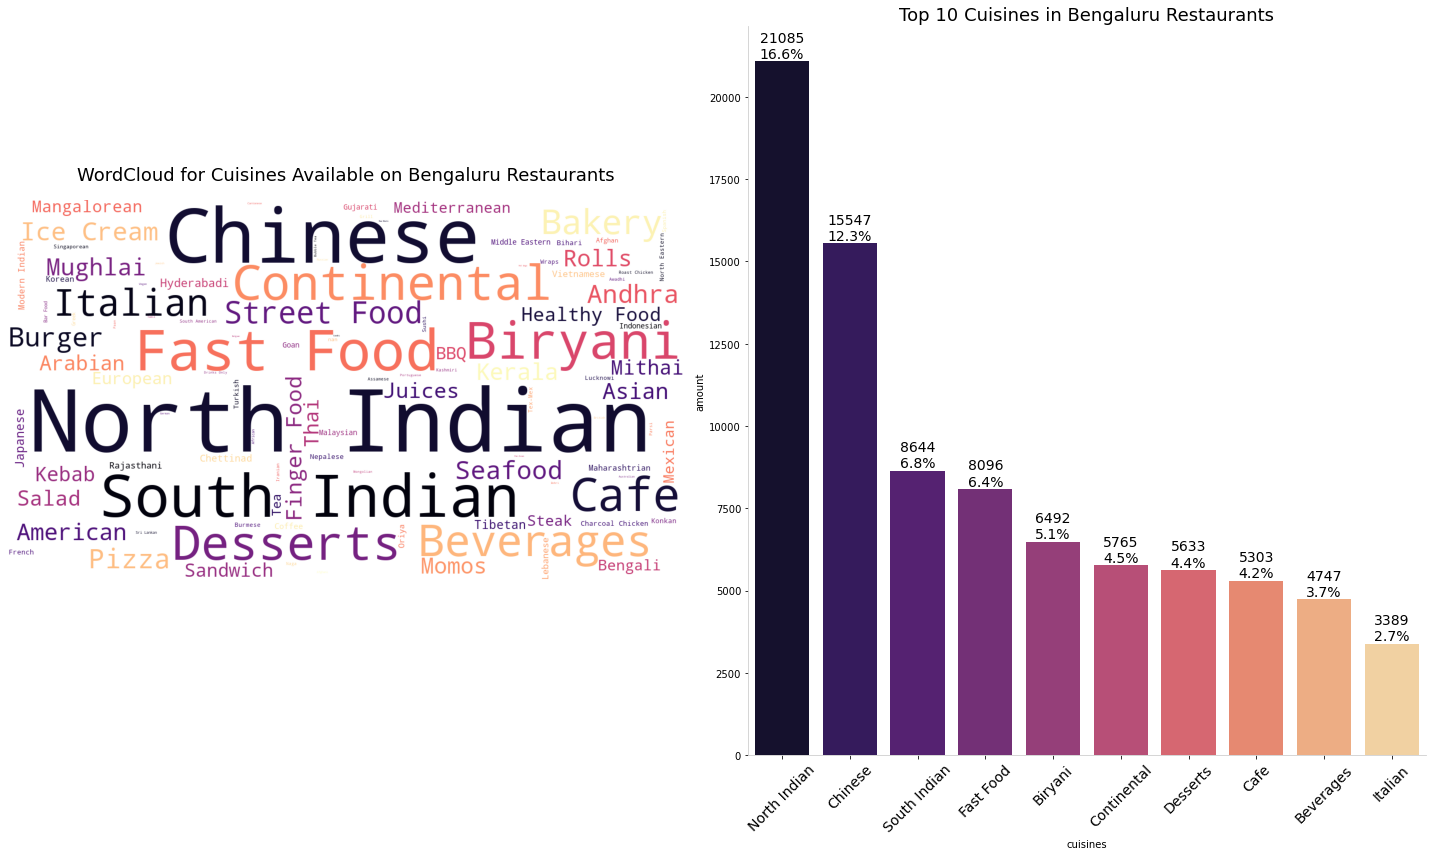

In [52]:
# Creating a list with all options available
cuisines = list(df_restaurants['cuisines'].astype(str).values)
cuisines_word_list = []
for lista in [c.split(',') for c in cuisines]:
    for word in lista:
        cuisines_word_list.append(word.strip())
        
# Creating a Counter for unique options and generating the wordcloud
cuisines_wc_dict = Counter(cuisines_word_list)

wordcloud = WordCloud(width=1280, height=720, collocations=False, random_state=42, 
                      colormap='magma', background_color='white').generate_from_frequencies(cuisines_wc_dict)

# Visualizing the WC created and the total for each cuisine
fig, axs = plt.subplots(1, 2, figsize=(20, 12))
ax1 = axs[0]
ax2 = axs[1]
ax1.imshow(wordcloud)
ax1.axis('off')
ax1.set_title('WordCloud for Cuisines Available on Bengaluru Restaurants', size=18, pad=20)

# Total for each cuisine
df_cuisines = pd.DataFrame()
df_cuisines['cuisines'] = cuisines_wc_dict.keys()
df_cuisines['amount'] = cuisines_wc_dict.values()
df_cuisines.sort_values(by='amount', ascending=False, inplace=True)
sns.barplot(x='cuisines', y='amount', data=df_cuisines.head(10), palette='magma', ax=ax2)
format_spines(ax2, right_border=False)
ax2.set_title('Top 10 Cuisines in Bengaluru Restaurants', size=18)

# Customizing chart
ncount = df_cuisines['amount'].sum()
x_ticks = [item.get_text() for item in ax2.get_xticklabels()]
ax2.set_xticklabels(x_ticks, rotation=45, fontsize=14)
for p in ax2.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax2.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), fontsize=14, ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### _(c) How many restaurants offer Book Table service? And how about Online Order service?_

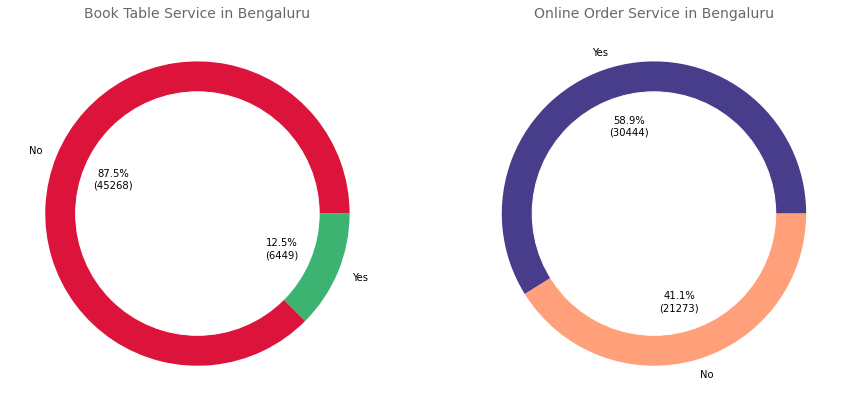

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
donut_plot(df_restaurants, col='book_table', colors=['crimson', 'mediumseagreen'], ax=axs[0], 
           title='Book Table Service in Bengaluru')
donut_plot(df_restaurants, col='online_order', colors=['darkslateblue', 'lightsalmon'], ax=axs[1], 
           title='Online Order Service in Bengaluru')

In [33]:
# Grouping data into location
good_ones = df_restaurants.groupby(by='location', as_index=False).agg({'votes': 'sum',
                                                                       'url': 'count',
                                                                       'approx_cost': 'mean',
                                                                       'rate_num': 'mean'})
good_ones.columns = ['location', 'total_votes', 'total_unities', 'mean_approx_cost', 'mean_rate_num']
good_ones['votes_per_unity'] = good_ones['total_votes'] / good_ones['total_unities']
good_ones = good_ones.sort_values(by='total_unities', ascending=False)
good_ones = good_ones.loc[:, ['location', 'total_unities', 'total_votes', 'votes_per_unity',
                                                'mean_approx_cost', 'mean_rate_num']]
good_ones.head(10)

,location,total_unities,total_votes,votes_per_unity,mean_approx_cost,mean_rate_num
0,BTM,5124,619376,120.877440,396.480973,3.573740
22,HSR,2523,499720,198.065795,475.610048,3.672164
45,Koramangala 5th Block,2504,2219506,886.384185,663.663845,4.005821
29,JP Nagar,2235,586593,262.457718,522.771300,3.675306
89,Whitefield,2144,466829,217.737407,598.152836,3.621618
27,Indiranagar,2083,1196007,574.175228,653.788027,3.828154
32,Jayanagar,1926,488080,253.416407,476.407716,3.780280
56,Marathahalli,1846,445201,241.170639,513.750683,3.541927
3,Bannerghatta Road,1630,219077,134.403067,443.679654,3.507449
6,Bellandur,1286,206027,160.207621,527.503888,3.525692


#### _(d) Where Are the Top Restaurants in Bengaluru?_

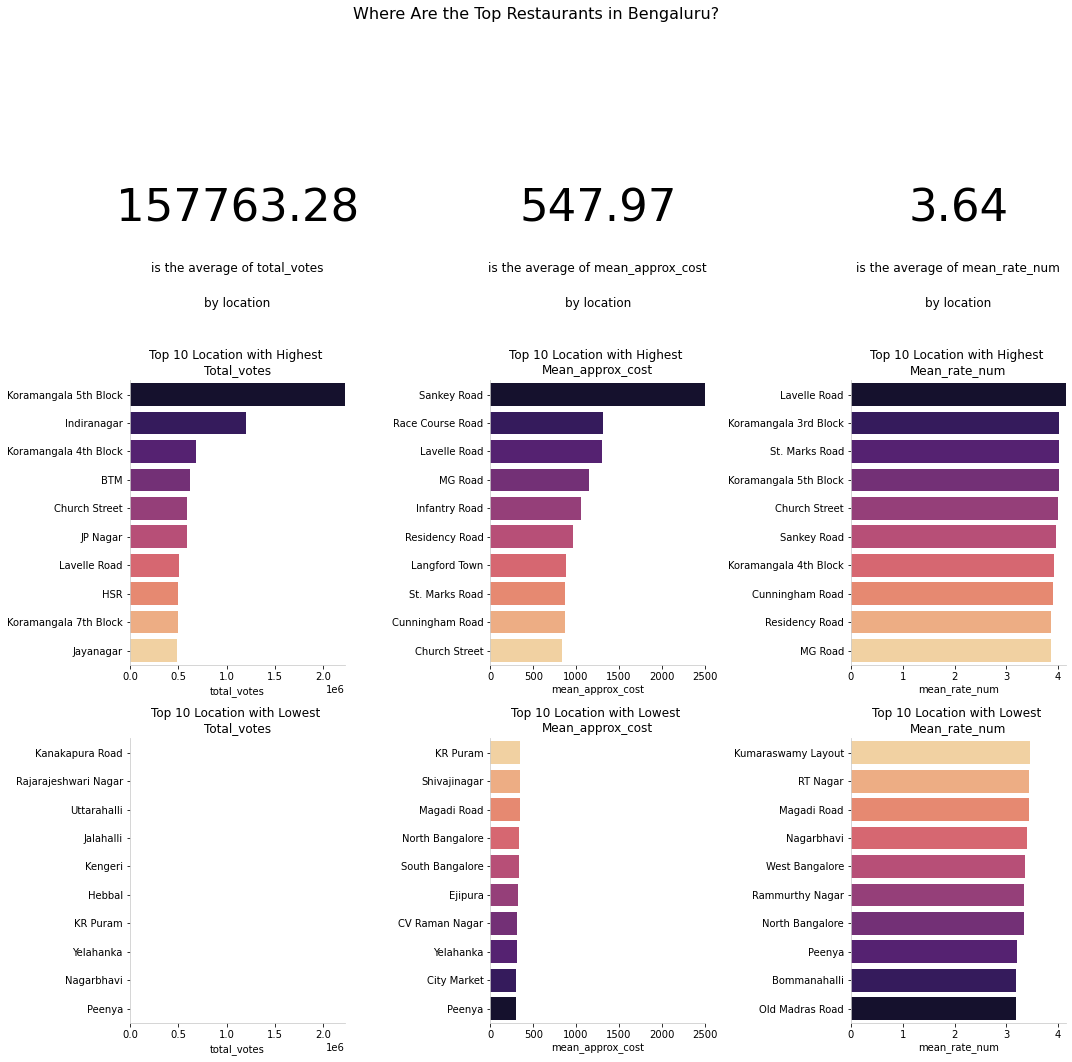

In [36]:
# Looking forward to put those numbers into a beautiful chart, let's use a homemade function called `answear_plot()` created to simulate the same analysis made for the best and worst restaurants in Bengaluru. This function can be found at the `viz_utils.py` module.
# Creating a figure por restaurants overview analysis
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
list_cols = ['total_votes', 'mean_approx_cost', 'mean_rate_num']

# PLotting best and worst by grouped data
answear_plot(grouped_data=good_ones, grouped_col='location', axs=axs, list_cols=list_cols, top=10, palette='magma')

# Finishing the chart
plt.suptitle('Where Are the Top Restaurants in Bengaluru?', size=16)
plt.tight_layout()
plt.show()

### 2.2 Geographical Exploration

In [ ]:
# In the following steps, the real idea was to extract lat and long features from the address
# in the dataset, but there are huge differences between address formats that made it difficult.
# So, maybe the best we can do here is to extract geolocation features based in the restaurant city. 

# Let's use the `Nominatim` API to help us doing this job. We will use an open user_agent.

In [40]:
# Extracting lat and long from the restaurant city using an API service
geolocator = Nominatim(user_agent="Y_BzShFZceZ_rj_t-cI13w")

# Creating a auxiliar dataset with cities location (reducing the API calls and time consuming by consequence)
cities_aux = pd.DataFrame(df_restaurants['listed_in(city)'].value_counts())
cities_aux.reset_index(inplace=True)
cities_aux.columns = ['city', 'total_restaurants']

# Extracting cities lat and long features
cities_aux['lat'] = cities_aux['city'].apply(lambda x: geolocator.geocode(x)[1][0])
cities_aux['lng'] = cities_aux['city'].apply(lambda x: geolocator.geocode(x)[1][1])

# Adding more features do further analysis
city_group = df_restaurants.groupby(by='listed_in(city)', as_index=False).agg({'votes': 'sum',
                                                                               'approx_cost': 'mean',
                                                                               'rate_num': 'mean'})
city_group.columns = ['city', 'total_votes', 'avg_approx_cost', 'avg_rate_num']

# Creating an unique city data
cities_aux = cities_aux.merge(city_group, how='left', on='city')

# Merging the original data to the grouped cities lat and long
df_restaurants = df_restaurants.merge(cities_aux, how='left', left_on='listed_in(city)', right_on='city')
df_restaurants.drop(['city', 'total_restaurants'], axis=1, inplace=True)

# Results on cities grouped data
cities_aux

,city,total_restaurants,lat,lng,total_votes,avg_approx_cost,avg_rate_num
0,BTM,3279,45.954851,-112.496595,985690,495.485145,3.707241
1,Koramangala 7th Block,2938,12.930264,77.633258,1065901,520.497598,3.758410
2,Koramangala 5th Block,2836,12.934377,77.628415,1040312,522.979026,3.760255
3,Koramangala 4th Block,2779,12.934334,77.630406,992065,528.353924,3.759035
4,Koramangala 6th Block,2623,12.940032,77.620327,978900,521.340524,3.763153
5,Jayanagar,2371,27.643927,83.052805,563880,469.077053,3.694969
6,JP Nagar,2096,12.265594,76.646540,395852,459.774904,3.629472
7,Indiranagar,1860,12.973291,77.640467,781831,654.753655,3.745659
8,Church Street,1827,40.714245,-74.007060,687895,771.990104,3.804262
9,MG Road,1811,29.453493,-98.644014,722679,763.987696,3.802023


#### _(a) Geo Analysis: where are the restaurants located in Bengaluru?_

In [42]:
# Zipping locations for folium map
locations = list(zip(df_restaurants['lat'].values, df_restaurants['lng'].values))

# Creating a map using folium
map1 = folium.Map(
    location=[12.97, 77.63],
    zoom_start=11.5
)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

## 3. Predicting the Success of a Restaurant

Finally, we predict the success of a restaurant in Bengaluru using the data provided and extracting some additional features. Here is the approach taken:

    1. Use the restaurant rate to classify our data in two classes: good and bad (thresholds to be defined)
    2. Create a target variable using a pre-defined rate threshold
    3. Extract features from the data
    4. Create a classification model using a supervisioned approach
    5. Predict the "probability for being a good restaurant" for the ones marked as NEW or without rate

### 3.1 Preprocessing

In [58]:
# Splitting restaurants
df_restaurants['rated'] = df_restaurants['rate_num'].apply(lambda x: 1 if x >= 0 else 0)
new_restaurants = df_restaurants.query('rated == 0')
train_val_restaurants = df_restaurants.query('rated == 1')

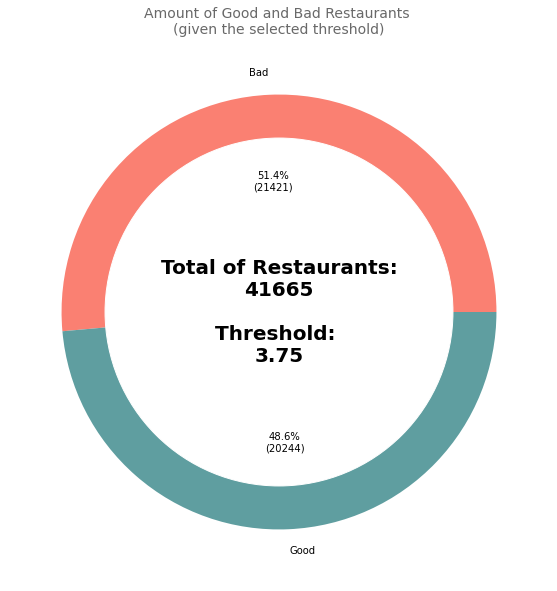

In [59]:
# Defining a custom threshold for splitting restaurants into good and bad
threshold = 3.75
train_val_restaurants['target'] = train_val_restaurants['rate_num'].apply(lambda x: 1 if x >= threshold else 0)

# Donut chart
fig, ax = plt.subplots(figsize=(10, 10))
label_names = ['Bad' if target == 0 else 'Good' for target in train_val_restaurants['target'].value_counts().index]
color_list = ['salmon' if label == 'Bad' else 'cadetblue' for label in label_names]
donut_plot(train_val_restaurants, col='target', ax=ax, label_names=label_names, 
           colors=color_list, title='Amount of Good and Bad Restaurants \n(given the selected threshold)',
           text=f'Total of Restaurants:\n{len(train_val_restaurants)}\n\nThreshold: \n{threshold}')

In [60]:
# Selecting initial features
initial_features = ['online_order', 'book_table', 'location', 'rest_type', 'cuisines', 
                    'listed_in(type)', 'listed_in(city)', 'approx_cost', 'target']
train_val_restaurants = train_val_restaurants.loc[:, initial_features]

# Extracting new features
train_val_restaurants['multiple_types'] = train_val_restaurants['rest_type'].astype(str).apply(lambda x: len(x.split(',')))
train_val_restaurants['total_cuisines'] = train_val_restaurants['cuisines'].astype(str).apply(lambda x: len(x.split(',')))

# Dropping another ones
train_val_restaurants.drop('cuisines', axis=1, inplace=True)
train_val_restaurants.head()

,online_order,book_table,location,rest_type,listed_in(type),listed_in(city),approx_cost,target,multiple_types,total_cuisines
0,Yes,Yes,Banashankari,Casual Dining,Buffet,Banashankari,800.0,1,1,3
1,Yes,No,Banashankari,Casual Dining,Buffet,Banashankari,800.0,1,1,3
2,Yes,No,Banashankari,"Cafe, Casual Dining",Buffet,Banashankari,800.0,1,2,3
3,No,No,Banashankari,Quick Bites,Buffet,Banashankari,300.0,0,1,2
4,No,No,Basavanagudi,Casual Dining,Buffet,Banashankari,600.0,1,1,2


Some considerations:

* We won't use the `votes` feature as long as this is a information we only know after launching a restaurant. As we want to be predictive, the idea is to return the probability of success of a restaurant before launching it.
* We created the `multiple_types`, `total_dishes` and `total_cuisines` features in a way of counting the food services offered by the restaurant. This is information can be gotten before the launching of the establishment.

In [61]:
# Splitting the data
X = train_val_restaurants.drop('target', axis=1)
y = train_val_restaurants['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [62]:
# Splitting features by data type
cat_features= [col for col, dtype in X_train.dtypes.items() if dtype == 'object']
num_features = [col for col, dtype in X_train.dtypes.items() if dtype != 'object']

# Apply encoding for categorical features
X_train_cat = X_train[cat_features]
for col in cat_features:
    col_encoded = pd.get_dummies(X_train_cat[col], prefix=col, dummy_na=True)
    X_train_cat = X_train_cat.merge(col_encoded, left_index=True, right_index=True)
    X_train_cat.drop(col, axis=1, inplace=True)
    
print(f'Total categorical features after encoding: {X_train_cat.shape[1]}')

Total categorical features after encoding: 226


### _3.2 Pipelining_

In a first approach, the pipeline will consider:

* Preparing the cost and rate attribute from raw data;
* Selecting initial features to be part of data prep;
* Creating new features based on original data;
* Creating a target for using on training;
* Splitting restaurants based on rated and non-rated ones;
* Encoding the data for categorical features;
* Filling the null data with meadian for numerical features;

In [67]:
# Class for applying initial prep on key columns
class PrepareCostAndRate(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Extracting the approx cost feature
        X['approx_cost'] = X['approx_cost(for two people)'].astype(str).apply(lambda x: x.replace(',', '.'))
        X['approx_cost'] = X['approx_cost'].astype(float)
        
        # Extracting the rate feature
        X['rate_num'] = X['rate'].astype(str).apply(lambda x: x.split('/')[0])
        while True:
            try:
                X['rate_num'] = X['rate_num'].astype(float)
                break
            except ValueError as e1:
                noise_entry = str(e1).split(":")[-1].strip().replace("'", "")
                #print(f'Threating noisy entrance on rate feature: {noise_entry}')
                X['rate_num'] = X['rate_num'].apply(lambda x: x.replace(noise_entry, str(np.nan)))              
        
        return X

# Class for selection the initial features
class InitialFeatureSelection(BaseEstimator, TransformerMixin):
    
    def __init__(self, initial_features=['online_order', 'book_table', 'location', 'rest_type', 'cuisines', 
                                         'listed_in(type)', 'listed_in(city)', 'approx_cost', 'rate_num']):
        self.initial_features = initial_features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.initial_features]
                
# Class for creating some features
class RestaurantAdditionalFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, multiples_types=True, total_cuisines=True, top_locations=10, top_cities=10, top_types=10):
        self.multiples_types = multiples_types
        self.total_cuisines = total_cuisines
        self.top_locations = top_locations
        self.top_cities = top_cities
        self.top_types = top_types
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Adding features based on counting of restaurant types and cuisines
        if self.multiples_types:
            X['multiple_types'] = X['rest_type'].astype(str).apply(lambda x: len(x.split(',')))
        if self.total_cuisines:
            X['total_cuisines'] = X['cuisines'].astype(str).apply(lambda x: len(x.split(',')))
            X.drop('cuisines', axis=1, inplace=True)
            
        # Creating for features for reducing granularity on location
        main_locations = list(X['location'].value_counts().index)[:self.top_locations]
        X['location_feature'] = X['location'].apply(lambda x: x if x in main_locations else 'Other')
        X.drop('location', axis=1, inplace=True)
        
        # Creating for features for reducing granularity on city
        main_cities = (X['listed_in(city)'].value_counts().index)[:self.top_cities]
        X['city_feature'] = X['listed_in(city)'].apply(lambda x: x if x in main_cities else 'Other')
        X.drop('listed_in(city)', axis=1, inplace=True)
        
        # Creating for features for reducing granularity on restaurant type
        main_rest_type = (X['rest_type'].value_counts().index)[:self.top_types]
        X['type_feature'] = X['rest_type'].apply(lambda x: x if x in main_rest_type else 'Other')
        X.drop('rest_type', axis=1, inplace=True)
        
        return X
            
# Class for creating a target based on a threshold (training only)
class CreateTarget(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=3.75):
        self.threshold = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['target'] = X['rate_num'].apply(lambda x: 1 if x >= self.threshold else 0)
        
        return X
    
# Class for splitting the data into new (not rated) and old (rated) restaurants
class SplitRestaurants(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Splits the restaurants based on rate column (rated and non rated)
        rated = X[~X['rate_num'].isnull()]
        non_rated = X[X['rate_num'].isnull()]
        
        # Dropping the rate column
        rated.drop('rate_num', axis=1, inplace=True)
        non_rated.drop('rate_num', axis=1, inplace=True)
        
        return rated, non_rated

In [69]:
# Reading raw data
data_path = 'zomato.csv'
raw_data = import_data(path=data_path, n_lines=5000)

# Defining a commoon pipeline to be applied after reading the raw data
common_pipeline = Pipeline([
    ('initial_preparator', PrepareCostAndRate()),
    ('selector', InitialFeatureSelection()),
    ('feature_adder', RestaurantAdditionalFeatures()),
    ('target_creator', CreateTarget()),
    ('new_splitter', SplitRestaurants())
])

# Applying the initial pipeline
train_restaurants, new_restaurants = common_pipeline.fit_transform(raw_data)
print(f'Total restaurants to be used on training: {len(train_restaurants)}')
print(f'Total restaurants to be used on prediction: {len(new_restaurants)}')

This dataset has 17 columns, which 1 is/are applicable to optimization.

----------------------------------------------------
Memory usage (5000 lines): 0.6486 MB
Memory usage after optimization (5000 lines): 0.6295 MB
----------------------------------------------------

Reduction of 2.94% on memory usage

Total restaurants to be used on training: 41665
Total restaurants to be used on prediction: 10052


In [72]:
# Splitting into training and testing data
X = train_restaurants.drop('target', axis=1)
y = train_restaurants['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

# Splitting into cat and num data
cat_features = [col for col, dtype in X_train.dtypes.items() if dtype == 'object']
num_features = [col for col, dtype in X_train.dtypes.items() if dtype != 'object']

# Building a numerical processing pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Building a categorical processing pipeline
cat_pipeline = Pipeline([
    ('encoder', DummiesEncoding(dummy_na=True))
])

# Building a complete Pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Applying the full pipeline into the data
X_train_prep = full_pipeline.fit_transform(X_train)
X_test_prep = full_pipeline.fit_transform(X_test)
print(f'Shape of X_train_prep: {X_train_prep.shape}')
print(f'Shape of X_test_prep: {X_test_prep.shape}')

# returning categorical features after encoding and creating a new set of features after the pipeline
encoded_features = full_pipeline.named_transformers_['cat']['encoder'].features_after_encoding
model_features = num_features + encoded_features
print(f'\nCheck! Number of features after the pipeline (must be the same as shape[1]): {len(model_features)}')

Shape of X_train_prep: (33332, 53)
Shape of X_test_prep: (8333, 53)

Check! Number of features after the pipeline (must be the same as shape[1]): 53


Finally, we come to the main point of our project: training a classification model to predict the probability of success (high rate) of a given restaurant. We have already went trough about 80% of work done on prep and transformations. So, for making this training step easier, let's use a homemade utility script called `ml_utils.py`. It contains a class called `BinaryClassifierAnalysis` with useful methods for training and evaluating selected classifiers.

For this task, let's train a `LogisticRegression`, `DecisionTrees`, `RandomForest` and `LightGBM` classifiers, each one using `RandomizedGridSearchCV` with 5 k-folds and hiperparameters pre-defined.

In [73]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Decision Trees hyperparameters
tree_param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 10, 20],
    'max_features': np.arange(1, X_train.shape[1]),
    'class_weight': ['balanced', None],
    'random_state': [42]
}

# Random Forest hyperparameters
forest_param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3, 5, 10, 20, 50],
    'n_estimators': [50, 100, 200, 500],
    'random_state': [42],
    'max_features': ['auto', 'sqrt'],
    'class_weight': ['balanced', None]
}

# LightGBM hyperparameters
lgbm_param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10),
}

lgbm_fixed_params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [74]:
# Setting up classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'DecisionTrees': {
        'model': DecisionTreeClassifier(),
        'params': tree_param_grid
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': forest_param_grid
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(**lgbm_fixed_params),
        'params': lgbm_param_grid
    }
}

### _3.3 Training and evaluating classifiers_

In [76]:
# Creating an instance for the homemade class BinaryClassifiersAnalysis
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train_prep, y_train, random_search=True, cv=5, verbose=5)

Training model LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training model DecisionTrees

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training model RandomForest

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training model LightGBM

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [

In [77]:
# Evaluating metrics
df_performances = clf_tool.evaluate_performance(X_train_prep, y_train, X_test_prep, y_test, cv=5)
df_performances.reset_index(drop=True).style.background_gradient(cmap='Blues')

Evaluating model LogisticRegression

Evaluating model DecisionTrees

Evaluating model RandomForest

Evaluating model LightGBM

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightG

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=

,model,approach,acc,precision,recall,f1,auc,total_time
0,LogisticRegression,Treino 5 K-folds,0.701500,0.731300,0.612100,0.666400,0.771400,5.741000
1,LogisticRegression,Teste,0.697900,0.727600,0.594600,0.654400,0.763600,0.024000
2,DecisionTrees,Treino 5 K-folds,0.727000,0.750800,0.658300,0.701400,0.779600,1.130000
3,DecisionTrees,Teste,0.721200,0.754000,0.624000,0.682900,0.778800,0.012000
4,RandomForest,Treino 5 K-folds,0.763000,0.803500,0.679700,0.736400,0.836800,64.200000
5,RandomForest,Teste,0.761800,0.807500,0.662700,0.728000,0.831900,0.269000
6,LightGBM,Treino 5 K-folds,0.744300,0.796600,0.638000,0.708500,0.817800,6.020000
7,LightGBM,Teste,0.734300,0.788100,0.612300,0.689100,0.807900,0.048000


It's very interesting to see that the `RandomForest` was the best classification model for our task. Meanwhile it's also the heaviest one in terms of time consuming. Let's use it for further evaluation.

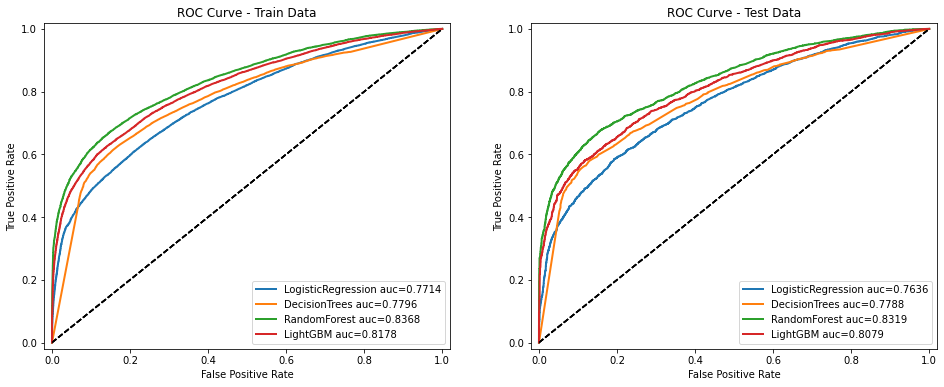

In [78]:
clf_tool.plot_roc_curve()
# clf_tool.plot_confusion_matrix(classes=['Good', 'Bad'])

## 4. Conclusions

Well, after going trough all the tasks we can conclude that it was possible to predict the success (in terms of rate) for new restaurants put in Zomato service. This is very interesting for business areas to evaluate the main concepts of restaurants and customers preferences in Bengaluru region. With this information, it's clearly possible to take a look at restaurant's features before launching it! The business men and the customers would appreciate it!

So, thinking of a developer way, it would be nice to code this as a production script that receives data from new restaurants monthly (or daily if you wish) and returns the "success score probability". For this to be true, we have to encapsulate a bunch of steps, like building (or reading) a complete pipeline in a pkl format, building (or reading) a classification model also in pkl format and, by the end, applying the `predict` or `predict_proba` methods for scoring the new data. Let's simulate it.

In [85]:
# Applying the full pipeline into new restaurants
new_restaurants_prep = full_pipeline.fit_transform(new_restaurants.drop('target', axis=1))

# Returning the best model and predicting the rate for new restaurants
model = clf_tool.classifiers_info['LightGBM']['estimator']
y_pred = model.predict(new_restaurants_prep)
y_probas = model.predict_proba(new_restaurants_prep)
y_scores = y_probas[:, 1]

# Labelling new data
new_restaurants['success_class'] = y_pred
new_restaurants['success_proba'] = y_scores
new_restaurants.head()

,online_order,book_table,listed_in(type),approx_cost,multiple_types,total_cuisines,location_feature,city_feature,type_feature,target,success_class,success_proba
72,No,No,Delivery,150.0,1,1,Other,Other,Quick Bites,0,0,0.189179
75,No,No,Delivery,500.0,2,2,Other,Other,"Takeaway, Delivery",0,0,0.253407
84,No,No,Delivery,100.0,1,2,Other,Other,Quick Bites,0,0,0.168101
90,No,No,Delivery,500.0,1,2,Other,Other,Delivery,0,0,0.252519
91,No,No,Delivery,400.0,2,1,Other,Other,"Takeaway, Delivery",0,0,0.233175


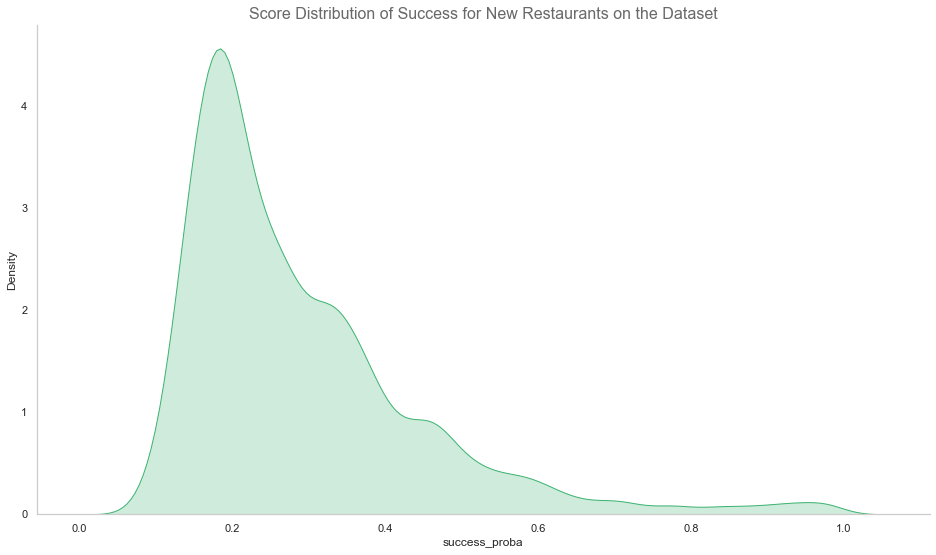

In [86]:
# Looking at the score distribution for new restaurants
fig, ax = plt.subplots(figsize=(16, 9))
sns.kdeplot(new_restaurants['success_proba'], ax=ax, shade=True, color='mediumseagreen')
format_spines(ax, right_border=False)
ax.set_title('Score Distribution of Success for New Restaurants on the Dataset', size=16, color='dimgrey')
plt.show()

### _What are the most promising restaurants (with the highest proba score)?_

In [87]:
# Ordering new restaurants by proba score
new_restaurants_data = new_restaurants.reset_index().merge(raw_data.reset_index()[['name', 'index']], how='left', on='index')
top_new = new_restaurants_data.sort_values(by='success_proba', ascending=False).head(10)
top_new = top_new.loc[:, ['name', 'success_proba', 'online_order', 'book_table', 'listed_in(type)',
                          'approx_cost', 'multiple_types', 'total_cuisines', 'location_feature',
                          'city_feature', 'type_feature']]
top_new

,name,success_proba,online_order,book_table,listed_in(type),approx_cost,multiple_types,total_cuisines,location_feature,city_feature,type_feature
4283,The Coastal Crew by Fujian on 24th,0.985100,Yes,Yes,Dine-out,1.1,2,5,JP Nagar,Jayanagar,"Casual Dining, Bar"
2302,Biergarten,0.984061,No,Yes,Pubs and bars,2.1,2,7,Koramangala 5th Block,BTM,Other
3941,Inntense Restobar,0.983848,No,Yes,Pubs and bars,1.6,2,5,Indiranagar,Indiranagar,Other
2198,Biergarten,0.983832,No,Yes,Dine-out,2.1,2,7,Koramangala 5th Block,BTM,Other
3937,Inntense Restobar,0.983234,No,Yes,Drinks & nightlife,1.6,2,5,Indiranagar,Indiranagar,Other
2298,Biergarten,0.982629,No,Yes,Drinks & nightlife,2.1,2,7,Koramangala 5th Block,BTM,Other
6483,Cheers Pub Bar & Restro,0.981865,No,Yes,Pubs and bars,1.1,2,5,Other,Koramangala 5th Block,Other
6481,Cheers Pub Bar & Restro,0.981690,No,Yes,Drinks & nightlife,1.1,2,5,Other,Koramangala 5th Block,Other
5929,Cheers Pub Bar & Restro,0.981606,No,Yes,Drinks & nightlife,1.1,2,5,Other,Koramangala 4th Block,Other
8480,By Chance,0.981168,No,Yes,Dine-out,1.1,2,4,Other,MG Road,Other


### _What are the least promising new/unrated restaurants (with the highest proba score)?_

In [88]:
# Ordering new restaurants by proba score
bottom_new = new_restaurants_data.sort_values(by='success_proba', ascending=True).head(10)
bottom_new = bottom_new.loc[:, ['name', 'success_proba', 'online_order', 'book_table', 'listed_in(type)',
                          'approx_cost', 'multiple_types', 'total_cuisines', 'location_feature',
                          'city_feature', 'type_feature']]
bottom_new

,name,success_proba,online_order,book_table,listed_in(type),approx_cost,multiple_types,total_cuisines,location_feature,city_feature,type_feature
4582,Sapid,0.071820,No,No,Delivery,250.0,1,1,Bannerghatta Road,JP Nagar,Delivery
4590,Jugz Cafe,0.071820,No,No,Delivery,250.0,1,1,Bannerghatta Road,JP Nagar,Delivery
1890,Sapid,0.074985,No,No,Delivery,250.0,1,1,Bannerghatta Road,BTM,Delivery
4614,Ambur Hotel,0.080392,No,No,Delivery,250.0,1,1,Bannerghatta Road,JP Nagar,Quick Bites
4611,A-1 Chicken Biriyani & Kababs,0.085364,No,No,Delivery,200.0,1,1,Bannerghatta Road,JP Nagar,Quick Bites
4584,Hotel Muthu,0.085364,No,No,Delivery,200.0,1,1,Bannerghatta Road,JP Nagar,Quick Bites
4546,Mr Shawarma,0.085364,No,No,Delivery,200.0,1,1,Bannerghatta Road,JP Nagar,Quick Bites
4785,Ambur Hotel,0.089011,No,No,Dine-out,250.0,1,1,Bannerghatta Road,JP Nagar,Quick Bites
4788,Basveshwara Khaanavali,0.089011,No,No,Dine-out,250.0,1,1,Bannerghatta Road,JP Nagar,Quick Bites
4774,Priyadharshini Hotel,0.089319,No,No,Dine-out,200.0,1,3,Bannerghatta Road,JP Nagar,Quick Bites


With this implementation it was possible to delivery useful information for Business areas and also for Zomato customers on choosing the best restaurant for ordering (specially the new ones). This is an example of what predictive models can do in practice.